# Time series analysis - Example code 16: A bit more on BJ prediction

**Lund University, Lund, Sweden**

See also code 15 for more details on BJ model prediction.

**Reference:**  
"An Introduction to Time Series Modeling", 4th ed, by Andreas Jakobsson  
Studentlitteratur, 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

import sys
sys.path.append('../TimeSeriesAnalysis-main/TimeSeriesAnalysis-main')


from tsa_lth.modelling import estimateARMA, estimateBJ
from tsa_lth.tools.poly import polydiv

## Simulate some processes (same as in code 14)

In [2]:
np.random.seed(0)                               # Set the seed (just done for the lecture!)

extraN = 1000
N = 1300
noLags = 30
pstart = 1000                                   # Determine where the validation data starts.

# Simulate some process (same as in code 14).
sX = 24
A1 = np.array([1, -1.8, 0.82])
C1 = np.array([1, 0, -0.8])
A3 = np.convolve(np.concatenate([[1], np.zeros(sX-1), [-1]]), [1, -0.4])
C3 = np.array([1, 0.8, 2.1])
B = np.array([1.2])
A2 = np.array([1])

# Generate the noise and the input signals.
z = lfilter(C1, A1, np.random.randn(N + extraN))
x = lfilter(C3, A3, np.random.randn(N + extraN))

# Form the output using the filtered input. Remove the initial samples.
y = lfilter(B, A2, x) + z
y = y[extraN-1:]
x = x[extraN-1:]
xM = x[:pstart]
yM = y[:pstart]

## Examine the data

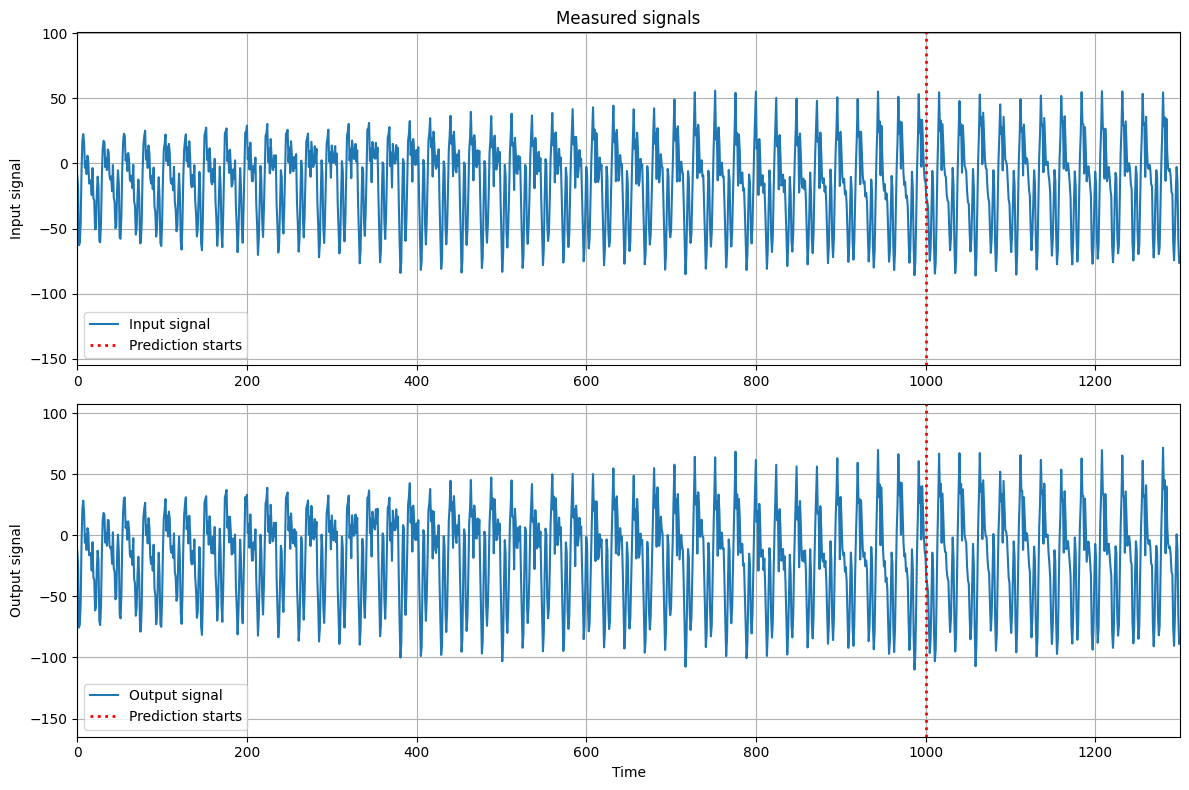

In [3]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(x)
ax1.axvline(x=pstart, color='red', linestyle=':', linewidth=2)
ax1.set_xlim([0, N])
ax1.set_ylim([np.min(x)*1.8, np.max(x)*1.8])
ax1.set_ylabel('Input signal')
ax1.set_title('Measured signals')
ax1.legend(['Input signal', 'Prediction starts'], loc='lower left')
ax1.grid(True)

ax2.plot(y)
ax2.axvline(x=pstart, color='red', linestyle=':', linewidth=2)
ax2.set_xlim([0, N])
ax2.set_ylim([np.min(y)*1.5, np.max(y)*1.5])
ax2.set_ylabel('Output signal')
ax2.set_xlabel('Time')
ax2.legend(['Output signal', 'Prediction starts'], loc='lower left')
ax2.grid(True)

plt.tight_layout()
plt.show()

## Estimate the BJ model

This is the model we found in code 15.

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 0.7892(±0.0319)·z⁻¹ + 0.175(±0.043)·z⁻²
C(z) = 1.0 + 0.3363(±0.0429)·z⁻² - 0.1825(±0.0391)·z⁻³

Polynomial orders: nA = 2    nC = 3
Number of free coefficients: 4
Fit to estimation data (NRMSE): 34.62%
FPE : 4.521  MSE : 4.484
AIC : 4229.347   BIC : 4248.869



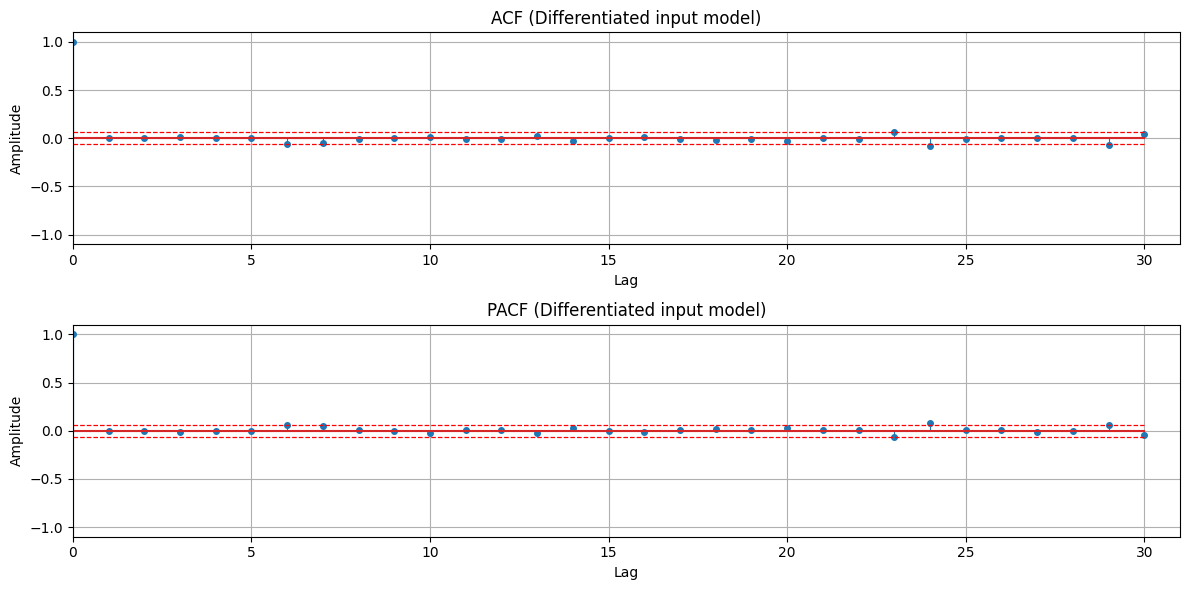

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 19.01 < 37.65)
  McLeod-Li test:        True (white if 17.17 < 37.65)
  Monti test:            True (white if 19.75 < 37.65)
  Sign change test:      True (white if 0.48 in [0.47,0.53])
Discrete-time BJ model: y(t) = B(z)x(t) + [C(z)/D(z)]e(t)

B(z) = 1.2003(±0.0006)
C(z) = 1.0 - 0.0524(±0.0447)·z⁻¹ - 0.7993(±0.042)·z⁻²
D(z) = 1.0 - 1.8126(±0.0374)·z⁻¹ + 0.8315(±0.0311)·z⁻²

Polynomial orders: nB = 0    nC = 2    nD = 2
Number of free coefficients: 5
Fit to estimation data (NRMSE): 97.4%
FPE : 0.946  MSE : 0.937
AIC : 2777.417   BIC : 2801.945



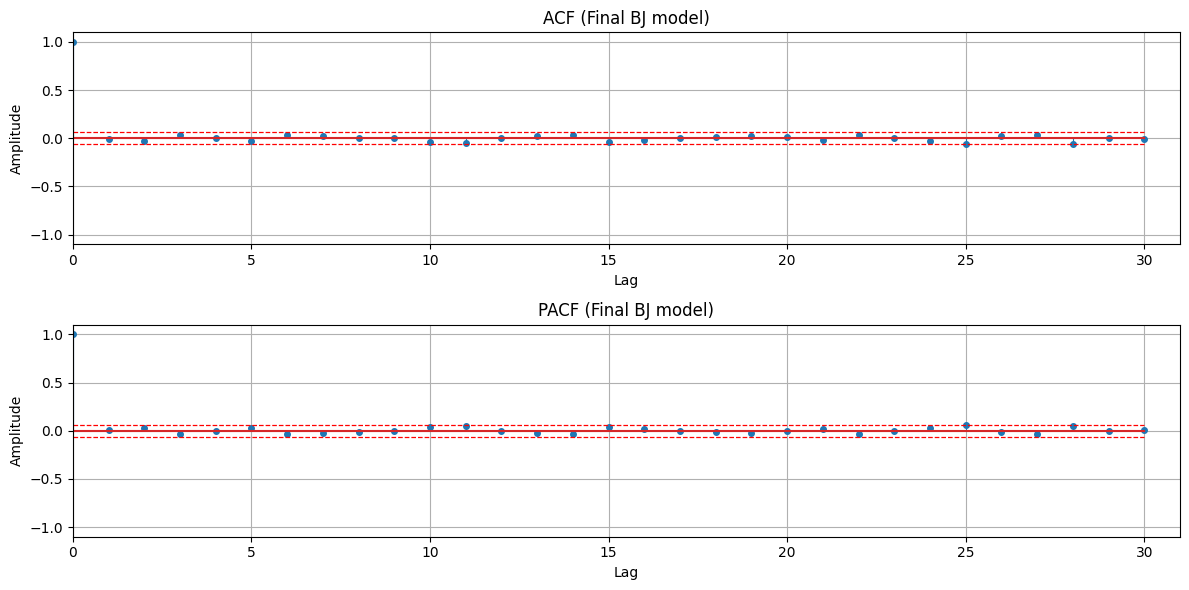

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 18.70 < 37.65)
  McLeod-Li test:        False (white if 43.34 < 37.65)
  Monti test:            True (white if 19.24 < 37.65)
  Sign change test:      True (white if 0.48 in [0.47,0.53])
Variance of input residual: 4.5077
Variance of output residual: 0.9436


In [4]:
# Differentiate the input
diff_xM = lfilter(np.concatenate([[1], np.zeros(sX-1), [-1]]), [1], xM)
diff_xM = diff_xM[sX+1:]

# Estimate input model
inputModel = estimateARMA(diff_xM, A=[1, 1, 1], C=[1, 0, 1, 1], 
                          titleStr='Differentiated input model', noLags=noLags)

# Add the differentiation to the model
inputModel.A = np.convolve(np.concatenate([[1], np.zeros(sX-1), [-1]]), inputModel.A)

# Estimate BJ model (mapping: C1=C, A1=D, A2=F, B=B)
foundModel = estimateBJ(yM, xM, B=[1], A2=[1], C1=[1, 0, 1], A1=[1, 1, 1], 
                        titleStr='Final BJ model', noLags=noLags)

# Calculate residuals and variances
ex = lfilter(inputModel.A, inputModel.C, xM)
ey = foundModel.resid

var_ex = np.var(ex[100:pstart], ddof=0)
var_ey = np.var(ey[100:pstart], ddof=0)

print(f'Variance of input residual: {var_ex:.4f}')
print(f'Variance of output residual: {var_ey:.4f}')

## Predict the future

Let's try to predict the future values, as if they were not known.  
Form the prediction for k=1, 2, 3, ...

In [5]:
kMax = 20                                       # How far ahead do we wish to predict.

# This is the predicted yt vector; it is known up to the start of the prediction.
pred_yk = y[:pstart-1].copy()
# This is the predicted xt vector; it is known up to the start of the prediction.
pred_xk = x[:pstart-1].copy()

# Extend the arrays to hold future predictions
pred_yk = np.concatenate([pred_yk, np.zeros(kMax)])
pred_xk = np.concatenate([pred_xk, np.zeros(kMax)])

# This is the variance of the predictions; zero up to the start of the prediction.
var_yk = np.zeros(pstart + kMax)
var_xk = np.zeros(pstart + kMax)

# Form the BJ prediction polynomials
KA = np.convolve(foundModel.D, foundModel.F)
KB = np.convolve(foundModel.D, foundModel.B)
KC = np.convolve(foundModel.F, foundModel.C)

lC3 = len(inputModel.C)
lKC = len(KC)

print(f'Computing predictions for k=1 to {kMax}...')

Computing predictions for k=1 to 20...


In [6]:
for k in range(1, kMax+1):
    # Compute the prediction polynomials for the input signal.
    Fx, Gx = polydiv(inputModel.C, inputModel.A, k)
    
    # Compute the prediction polynomials for the output signal.
    Fy, Gy = polydiv(foundModel.C, foundModel.D, k)
    Fhh, Ghh = polydiv(np.convolve(Fy, KB), KC, k)
    
    # Predict the input signal.
    i = pstart - 1 + k - 1
    pred_xk[i] = Gx @ x[i:i-len(Gx):-1] - \
                 inputModel.C[1:] @ pred_xk[i-1:i-lC3:-1]
    
    # Predict the output signal.
    FhhKC = np.convolve(Fhh, KC)
    pred_yk[i] = FhhKC @ pred_xk[i:i-len(FhhKC):-1] + \
                 Ghh @ x[i:i-len(Ghh):-1] + \
                 Gy @ y[i:i-len(Gy):-1] - \
                 KC[1:] @ pred_yk[i-1:i-lKC:-1]
    
    # The theoretical variances.
    var_xk[i] = np.sum(Fx**2) * var_ex
    var_yk[i] = np.sum(Fy**2) * var_ey + np.sum(Fhh**2) * var_xk[i]

print('Predictions complete!')

Predictions complete!


## Plot the output prediction and compare to validation data

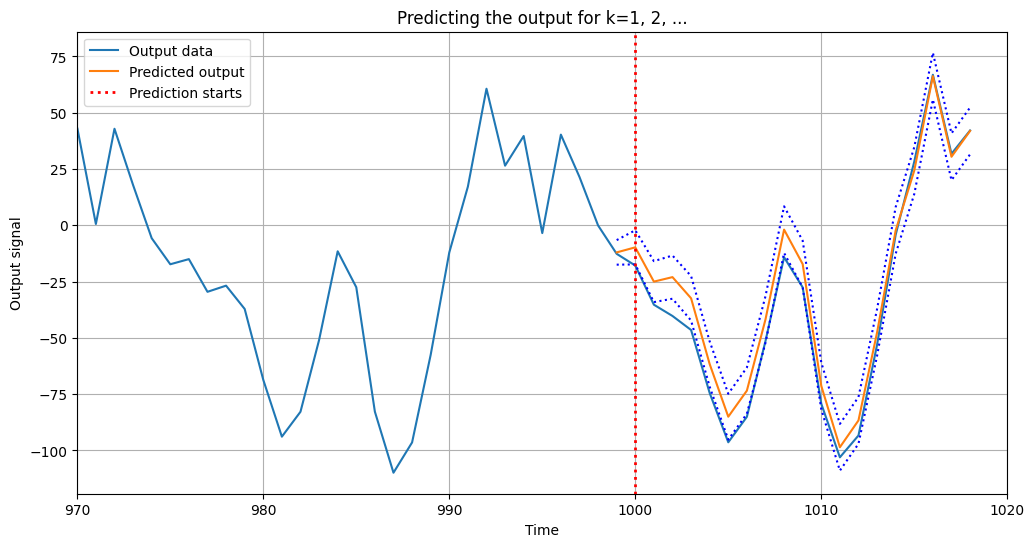

In [7]:
indV = np.arange(pstart-1, pstart+kMax-1)

plt.figure(figsize=(12, 6))
plt.plot(y[:pstart+kMax-1], label='Output data')
plt.plot(np.arange(pstart-1, pstart+kMax-1), pred_yk[pstart-1:pstart+kMax-1], label='Predicted output')
plt.plot(indV, pred_yk[indV] + 2*np.sqrt(var_yk[indV]), 'b:', linewidth=1.5)
plt.plot(indV, pred_yk[indV] - 2*np.sqrt(var_yk[indV]), 'b:', linewidth=1.5)
plt.axvline(x=pstart, color='red', linestyle=':', linewidth=2, label='Prediction starts')
plt.xlim([pstart-30, pstart+kMax])
plt.legend(loc='upper left')
plt.title('Predicting the output for k=1, 2, ...')
plt.xlabel('Time')
plt.ylabel('Output signal')
plt.grid(True)
plt.show()

## Plot the theoretical output variance

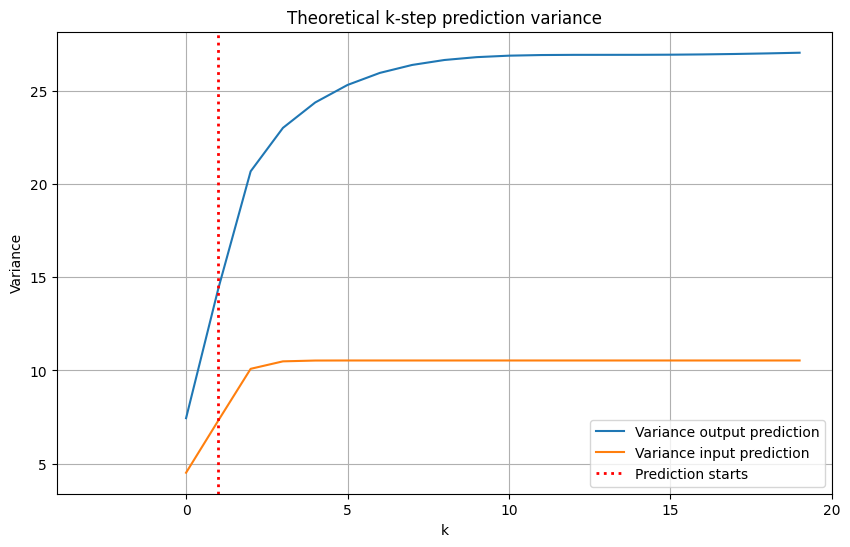

In [8]:
indV = np.arange(pstart-1, pstart+kMax-1)
k_values = indV - pstart + 1

plt.figure(figsize=(10, 6))
plt.plot(k_values, var_yk[indV], label='Variance output prediction')
plt.plot(k_values, var_xk[indV], label='Variance input prediction')
plt.axvline(x=1, color='red', linestyle=':', linewidth=2, label='Prediction starts')
plt.xlim([-4, kMax])
plt.title('Theoretical k-step prediction variance')
plt.xlabel('k')
plt.ylabel('Variance')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()